In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep

from pandas_datareader import data as pdr
import pandas_ta as ta #commented out for me for now, I (Ben) had some dependency issues

import yfinance as yf
# import quandl as qd # not used, ignor ples
from backtesting import Backtest, Strategy

C:\Users\Staro\.virtualenvs\dsc190-FVH1D0fH\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
yf.pdr_override() # for use with pandas-datareader, optional

uncomment below if you need to update/generate your monthly and daily csv files.

In [3]:
# ticker = pd.read_csv('ticker.csv')['Ticker']
# tickers = ticker.to_list() # This is a list of all tickers in the SP500
# tickers = [x.replace('.','-') for x in tickers] # yahoo has '-' instead of '.' for tickers, eg BRK.B

# ## below is how I got monthly and daily pandas dataframes of all stocks in one huge dict.  
# monthly_sp500 = {}
# daily_sp500 = {}
# for tkr in tickers: # run all 500 at your own risk, it takes a while lol
# # for tkr in tickers[:10]:
#     print('Grabbing ' + tkr + " data!")
#     monthly_sp500[tkr] = pdr.get_data_yahoo(tkr, start="2010-01-01", interval = "1mo")
#     daily_sp500[tkr] = pdr.get_data_yahoo(tkr,start="2010-01-01")
#     sleep(.1) # not planning on ddos-ing yahoo today
# monthly_sp500['AAPL'] # take AAPL, for example

# ## everything in one stupid large dataframe
# sp500m = monthly_sp500[tickers[0]] # monthly
# sp500m['Name'] = tickers[0]

# sp500d = daily_sp500[tickers[0]] # daily
# sp500d['Name'] = tickers[0]

# # for tkr in tickers[1:10]:
# for tkr in tickers[1:]:
#     df1 = monthly_sp500[tkr] # monthly
#     df1['Name'] = tkr
#     sp500m = sp500m.append(df1)

#     df2 = daily_sp500[tkr] # daily
#     df2['Name'] = tkr
#     sp500d = sp500d.append(df2)

# sp500m.to_csv('SP500_monthly.csv') # run/uncomment some of these to save these to csv
# sp500d.to_csv('SP500_daily.csv')

In [4]:
# df = pd.read_csv('SP500_monthly.csv').infer_objects().dropna()
df = pd.read_csv('SP500_daily.csv').infer_objects().dropna()
# df = sp500m.infer_objects().dropna()#.reset_index() # dataframe of all we basically want, OHLC data w/ adjusted close. didnt set any ind
df

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600.0,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.594968,601904800.0,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.490066,552160000.0,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.478067,477131200.0,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.521136,447610800.0,AAPL
...,...,...,...,...,...,...,...,...
1365206,2021-03-04,23.020000,23.330000,22.389999,22.770000,22.770000,345900.0,NWS
1365207,2021-03-05,22.940001,23.549999,22.510000,23.500000,23.500000,515500.0,NWS
1365208,2021-03-08,23.500000,23.760000,22.980000,23.230000,23.230000,754500.0,NWS
1365209,2021-03-09,24.000000,24.459999,23.389999,23.799999,23.799999,632600.0,NWS


In [5]:
# j=1
# k=2
# # the 'midpoints' for each observe and hold period. midpoint in this context is where we switch from the observation period len=j to the holding period len=k
# j_end = pd.date_range(st+pd.DateOffset(months=j*3), et, freq=str(k*3)+"MS")
# j_end.strftime("%Y-%m-%d").to_list()[:10]

In [6]:
# pd.date_range(st+pd.DateOffset(days=j), et)

In [7]:
# def generate_momentum_returns(j=25,k=50):
def generate_daily_timetable(j=10, k=20):
    '''aims to generate the MONTHLY table of times for each observe/hold period. The midpoint in this context is where we switch from the observation period len=j to the holding period len=k'''
    j_end = pd.date_range(pd.to_datetime(df.Date.min())+pd.DateOffset(days=j), pd.to_datetime(df.Date.max()), freq=str(k)+"D") # the 'midpoints' for each observe and hold period. 
    j_start = j_end + pd.DateOffset(days=-j) # based on the midpoint, get the start point for each observe and hold period
    k_end = j_end + pd.DateOffset(days=k-1) # based on the midpoint, get the end point for each observe and hold period
    timetable = pd.DataFrame({'j_start': j_start, 'midpoint': j_end, 'k_end': k_end}).infer_objects()
    return timetable, j, k
timedf, j, k = generate_daily_timetable()
print(timedf.shape[0])
timedf.head() ##NOTE THE K_END VALUE IS NO LONGER EQUAL TO THE NEXT MIDPOINT BUT OFFSET BY 1

204


,j_start,midpoint,k_end
0,2010-01-04,2010-01-14,2010-02-02
1,2010-01-24,2010-02-03,2010-02-22
2,2010-02-13,2010-02-23,2010-03-14
3,2010-03-05,2010-03-15,2010-04-03
4,2010-03-25,2010-04-04,2010-04-23


In [8]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600.0,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.594968,601904800.0,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.490066,552160000.0,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.478067,477131200.0,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.521136,447610800.0,AAPL
...,...,...,...,...,...,...,...,...
1365206,2021-03-04,23.020000,23.330000,22.389999,22.770000,22.770000,345900.0,NWS
1365207,2021-03-05,22.940001,23.549999,22.510000,23.500000,23.500000,515500.0,NWS
1365208,2021-03-08,23.500000,23.760000,22.980000,23.230000,23.230000,754500.0,NWS
1365209,2021-03-09,24.000000,24.459999,23.389999,23.799999,23.799999,632600.0,NWS


In [9]:
from itertools import chain
def get_daily_j(id=-1):
    jtimes = pd.DataFrame(list(chain.from_iterable(pd.date_range(timedf["j_start"],timedf["midpoint"]) for _,timedf in timedf.iterrows())), columns=("date",))
    jtimes['date'] = jtimes['date'].astype('datetime64[ns]')
    jtimes['period'] = (jtimes['date'].isin(timedf['midpoint'])).shift(1).cumsum().fillna(0).astype(int)
    df_ = df.copy()
    if 'date' not in df_.columns: 
        df_['date'] = pd.to_datetime(df_['Date'])
    df_['date'] = pd.to_datetime(df_['date'])
    df_ = df_.merge(jtimes, how='inner', left_on='date', right_on='date')
    if id==-1: 
        return df_ # this filters out periods that dont end prettily
    else:
        return df_[df_['period']==id].drop(columns='period')
# get_j_df = get_daily_j
def get_daily_k(id=-1):
    ktimes = pd.DataFrame(list(chain.from_iterable(pd.date_range(timedf["midpoint"],timedf["k_end"]) for _,timedf in timedf.iterrows())), columns=("date",))
    ktimes['date'] = ktimes['date'].astype('datetime64[ns]')
    ktimes['period'] = (ktimes['date'].isin(timedf['k_end'])).shift(1).cumsum().fillna(0).astype(int)
    df_ = df.copy()
    if 'date' not in df_.columns: 
        df_['date'] = pd.to_datetime(df_['Date'])
    df_['date'] = pd.to_datetime(df_['date'])
    df_ = df_.merge(ktimes, how='inner', left_on='date', right_on='date')
    if id==-1: 
        return df_ # this filters out periods that dont end prettily
    else:
        return df_[df_['period']==id].drop(columns='period')
get_daily_j()#.period.plot()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,date,period
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600.0,AAPL,2010-01-04,0
1,2010-01-04,30.620001,31.100000,30.590000,30.950001,24.049969,38409100.0,MSFT,2010-01-04,0
2,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900.0,AMZN,2010-01-04,0
3,2010-01-04,313.788788,315.070068,312.432434,313.688690,313.688690,3908488.0,GOOGL,2010-01-04,0
4,2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927065.0,GOOG,2010-01-04,0
...,...,...,...,...,...,...,...,...,...,...
750681,2021-02-25,32.490002,33.110001,31.750000,31.910000,31.910000,1604200.0,VNT,2021-02-25,203
750682,2021-02-25,21.940001,22.620001,21.490000,21.590000,21.590000,6187100.0,UAA,2021-02-25,203
750683,2021-02-25,25.309999,25.790001,24.920000,25.350000,25.350000,3828900.0,XRX,2021-02-25,203
750684,2021-02-25,18.280001,18.870001,18.020000,18.100000,18.100000,2355480.0,UA,2021-02-25,203


In [10]:
get_daily_j(0)

,Date,Open,High,Low,Close,Adj Close,Volume,Name,date
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600.0,AAPL,2010-01-04
1,2010-01-04,30.620001,31.100000,30.590000,30.950001,24.049969,38409100.0,MSFT,2010-01-04
2,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900.0,AMZN,2010-01-04
3,2010-01-04,313.788788,315.070068,312.432434,313.688690,313.688690,3908488.0,GOOGL,2010-01-04
4,2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927065.0,GOOG,2010-01-04
...,...,...,...,...,...,...,...,...,...
4053,2010-01-14,13.330000,13.455000,13.120000,13.335000,7.969944,897000.0,HFC,2010-01-14
4054,2010-01-14,20.080000,20.100000,19.620001,19.740000,14.824924,10180300.0,GPS,2010-01-14
4055,2010-01-14,52.028835,53.202885,51.493305,52.100925,37.844513,1401541.0,SLG,2010-01-14
4056,2010-01-14,3.633750,3.643750,3.583750,3.612500,3.612500,5499200.0,UAA,2010-01-14


In [11]:
get_daily_j()#.period.plot()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,date,period
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600.0,AAPL,2010-01-04,0
1,2010-01-04,30.620001,31.100000,30.590000,30.950001,24.049969,38409100.0,MSFT,2010-01-04,0
2,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900.0,AMZN,2010-01-04,0
3,2010-01-04,313.788788,315.070068,312.432434,313.688690,313.688690,3908488.0,GOOGL,2010-01-04,0
4,2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927065.0,GOOG,2010-01-04,0
...,...,...,...,...,...,...,...,...,...,...
750681,2021-02-25,32.490002,33.110001,31.750000,31.910000,31.910000,1604200.0,VNT,2021-02-25,203
750682,2021-02-25,21.940001,22.620001,21.490000,21.590000,21.590000,6187100.0,UAA,2021-02-25,203
750683,2021-02-25,25.309999,25.790001,24.920000,25.350000,25.350000,3828900.0,XRX,2021-02-25,203
750684,2021-02-25,18.280001,18.870001,18.020000,18.100000,18.100000,2355480.0,UA,2021-02-25,203


In [12]:
# def generate_timetable(j=1, k=2):
#     '''aims to generate the MONTHLY table of times for each observe/hold period. The midpoint in this context is where we switch from the observation period len=j to the holding period len=k'''
    
#     j_end = pd.date_range(st+pd.DateOffset(months=j*3), et, freq=str(k*3)+"MS") # the 'midpoints' for each observe and hold period. 
#     j_start = j_end + pd.DateOffset(months=-j*3) # based on the midpoint, get the start point for each observe and hold period
#     k_end = j_end + pd.DateOffset(months=k*3) # based on the midpoint, get the end point for each observe and hold period
#     timetable = pd.DataFrame({'j_start': j_start, 'midpoint': j_end, 'k_end': k_end}).infer_objects()
#     return timetable, j, k
# timedf, j, k = generate_timetable(3, 2)
# timedf.head()

In [13]:
df['Date']

0          2010-01-04
1          2010-01-05
2          2010-01-06
3          2010-01-07
4          2010-01-08
              ...    
1365206    2021-03-04
1365207    2021-03-05
1365208    2021-03-08
1365209    2021-03-09
1365210    2021-03-10
Name: Date, Length: 1365210, dtype: object

In [14]:
midpoint = timedf.iloc[0].midpoint

In [15]:
# def get_j_df(id=-1, j=j):
#     '''this should spit out a dataframe of data in the observational period j given specific id or midpoint value. 
#     if unspecified it throws all of them at you with an extra identifying column "periods"'''
#     if (id==-1): # not really sure why we need this but ill include it. this adds a sector column to the data for future filtering purposes if needed
#         df_i = pd.DataFrame(columns=df.columns.to_list()+['period']) #dummy empty df
#         for i in timedf.index: 
#             # print(timedf.iloc[i].j_start,timedf.iloc[i].midpoint)
#             df_ = df[(timedf.iloc[i].j_start <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[i].midpoint)] # gets dates btw start and midpt
#             df_['period'] = i
#             df_i = pd.concat([df_i, df_])

#         return df_i
#     return df[(timedf.iloc[id].j_start <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[id].midpoint)] # gets dates btw start and midpt from table
# get_j_df(0)

In [16]:
# def get_k_df(id=-1, k=k):
#     '''this should spit out a dataframe of data in the holding period k given specific id or midpoint value. 
#     if unspecified it throws all of them at you with an extra identifying column "periods"'''
#     if (id==-1): # we can decide if this is useful later this adds a sector column to the data for future filtering purposes if needed
#         df_i = pd.DataFrame(columns=df.columns.to_list()+['period']) #dummy empty df
#         for i in timedf.index: 
#             # print(timedf.iloc[i].j_start,timedf.iloc[i].midpoint)
#             df_ = df[(timedf.iloc[i].midpoint <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[i].k_end)] # gets dates btw midpt and end
#             df_['period'] = i
#             df_i = pd.concat([df_i, df_])

#         return df_i
#     return df[(timedf.iloc[id].midpoint <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[id].k_end)] # gets dates btw midpt and end
# get_k_df()

# Data Analysis: using the above functions for building portfolios

In [17]:
timedf,j,k = generate_daily_timetable(j=10, k=20) # with j as 3 and k as 2
timedf

,j_start,midpoint,k_end
0,2010-01-04,2010-01-14,2010-02-02
1,2010-01-24,2010-02-03,2010-02-22
2,2010-02-13,2010-02-23,2010-03-14
3,2010-03-05,2010-03-15,2010-04-03
4,2010-03-25,2010-04-04,2010-04-23
...,...,...,...
199,2020-11-27,2020-12-07,2020-12-26
200,2020-12-17,2020-12-27,2021-01-15
201,2021-01-06,2021-01-16,2021-02-04
202,2021-01-26,2021-02-05,2021-02-24


In [18]:
df0 = get_daily_j(0).set_index('Name') # i dont know why, but you have to set index to name for the groupby's to work
df0['pct_change'] = df0['Adj Close'].groupby('Name').pct_change()
df0['cum_return'] = (df0['pct_change']+1).groupby('Name').cumprod().fillna(1)-1
df0['adj_close_shifted'] = df0['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
df0['adj_change'] = df0['Adj Close']/df0['adj_close_shifted'] #.bfill(0) 

features = df0.groupby('Name').tail(1).sort_values(['cum_return'], ascending=False)
features

,Date,Open,High,Low,Close,Adj Close,Volume,date,pct_change,cum_return,adj_close_shifted,adj_change
Name,,,,,,,,,,,,
DPZ,2010-01-14,10.800000,11.570000,10.700000,11.310000,9.616241,5085400.0,2010-01-14,0.100194,0.302995,8.026290,1.198093
ILMN,2010-01-14,40.150002,40.330002,38.439999,39.029999,39.029999,3640600.0,2010-01-14,-0.036534,0.277578,33.820000,1.154051
MGM,2010-01-14,12.370000,12.870000,12.220000,12.380000,11.700339,37690800.0,2010-01-14,-0.000807,0.272354,10.301594,1.135780
LEN,2010-01-14,16.243855,16.558504,16.007866,16.076696,15.112182,5075644.0,2010-01-14,0.006154,0.256726,15.028997,1.005535
ZION,2010-01-14,16.360001,16.850000,16.250000,16.709999,14.602304,4677900.0,2010-01-14,0.022018,0.253563,14.427528,1.012114
...,...,...,...,...,...,...,...,...,...,...,...,...
PWR,2010-01-14,20.209999,20.400000,19.340000,19.440001,19.238916,5720000.0,2010-01-14,-0.057683,-0.084746,20.762983,0.926597
URI,2010-01-14,8.970000,9.000000,8.870000,8.980000,8.980000,1102000.0,2010-01-14,0.002232,-0.105578,9.300000,0.965591
EXPE,2010-01-14,46.799999,48.040001,46.040001,46.119999,30.376251,2316950.0,2010-01-14,-0.021638,-0.106894,31.654005,0.959634


In [19]:
# monthly_sp500['PYPL'].head() # TODO we should write about some of the issues of yahoofinance as a datasource, that should be sufficient

In [20]:
# this calculates the winner and loser tickers given n
n = 50
get_percents = lambda n: features.shape[0]//n+1 # this function gets us n percent number of tickers
winner_tickers = features[:get_percents(n)].index
winner_tickers

Index(['DPZ', 'ILMN', 'MGM', 'LEN', 'ZION', 'RF', 'HBAN', 'TXT', 'IT', 'DAL'], dtype='object', name='Name')

In [21]:
loser_tickers = features[-get_percents(n):].index
loser_tickers

Index(['T', 'AMD', 'MPWR', 'ALGN', 'CRM', 'PWR', 'URI', 'EXPE', 'GPN', 'TMUS'], dtype='object', name='Name')

In [22]:
# equally weight
weights = np.ones(get_percents(n))/(get_percents(n))

In [23]:
winner_df0 = df0.loc[winner_tickers.to_list()]
winner_df0 = winner_df0.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0) # 
winner_df0
# winner_df0.dot(weights) # gives us the percent change of the portfolios
winner_performance = (winner_df0.dot(weights)+1).cumprod() - 1 # gets cumulative return for a period
winner_performance

Date
2010-01-04    0.000000
2010-01-05    0.027465
2010-01-06    0.051667
2010-01-07    0.129314
2010-01-08    0.128945
2010-01-11    0.152255
2010-01-12    0.175668
2010-01-13    0.202810
2010-01-14    0.236339
dtype: float64

In [24]:
def get_cum_return(data):
    '''gets cumulative return based on adjusted closing price of all tickers in input dataframe'''
    df_ = data.set_index('Name')

    # df_['pct_change'] = df_['Adj Close'].groupby('Name').pct_change()
    df_['pct_change'] = df_['Adj Close'].groupby('Name').pct_change()
    df_['cum_return'] = (df_['pct_change']+1).groupby('Name').cumprod().fillna(1)-1
    df_['adj_close_shifted'] = df_['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
    df_['adj_change'] = df_['Adj Close']/df_['adj_close_shifted'] #.bfill(0) 
    df_['adj_close_shifted'] = df_['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
    df_['adj_change'] = df_['Adj Close']/df_['adj_close_shifted'] #.bfill(0) 
    
    return df_

def get_percents(n): 
    '''this function gets us n percent number of tickers'''
    return features.shape[0]//n+1

def get_portfolios(period=0, n=50):   
    '''returns the portfolios we want from a particular period'''
    ## Gets the portfolio(s) in question we want to look at
    data = get_cum_return(get_daily_j(period))
    features = data.groupby('Name').tail(1).sort_values(['cum_return'], ascending=False) # sorts tickers by cumulative return

    winner_tickers = features[:get_percents(n)].index # we get the top/bottom n percent tickers
    loser_tickers = features[-get_percents(n):].index # only winner and loser portfolios for now, we could expand later
    # TODO add more portfolios if we have time
    # print(len(winner_tickers), len(loser_tickers))
    print('.', end='')
    return (winner_tickers.to_list(), loser_tickers.to_list())

def get_portfolio_performance(period=0, n=2, weights=None, hold=False):
    '''Gets all portfolios' cumulative return performance based on n period 
    keyword args:
    period      -- the nth period of data we are looking at, default 0
    portfolio   -- the particular type of portfolio we want to be looking at (winner or loser, etc) default winner/momentum
    n           -- the percentage of tickers we want to be looking at
    weights     -- how to weight the portfolio values. if unspecified (None) we assume equal weighting in the portfolio
    hold        -- if true returns the performance evaluation of the holding period k, else returns the performance of the observation period j
    '''
    winner_tickers, loser_tickers = get_portfolios(period, n)

    ## evaluates the performance of portfolios on either hold or observational data
    eval_df = get_cum_return(get_k_df(period)) if hold else get_cum_return(get_daily_j(period))# we get the return from the hold period
    
    weights = np.ones(get_percents(n))/(get_percents(n)) if not weights else weights # set weights
    print('weights', len(weights))
    winner_eval = eval_df.loc[winner_tickers] # first the winners
    winner_eval = winner_eval.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0)
    winner_performance = (winner_eval.dot(weights)+1).cumprod() - 1 # cumulative return

    loser_eval = eval_df.loc[loser_tickers] # then the losers
    loser_eval = loser_eval.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0)
    loser_performance = (loser_eval.dot(weights)+1).cumprod() - 1 # cumulative return

    output = pd.DataFrame({'winners': winner_performance, 'losers': loser_performance})
    return output
get_portfolio_performance()

.weights 226


,winners,losers
Date,,
2010-01-04,0.000000,0.000000
2010-01-05,0.011233,-0.003176
2010-01-06,0.019181,-0.006703
2010-01-07,0.033485,-0.008937
2010-01-08,0.038624,-0.008034
2010-01-11,0.044524,-0.008212
2010-01-12,0.037897,-0.022858
2010-01-13,0.050982,-0.014785
2010-01-14,0.057363,-0.018062


In [25]:
get_portfolios(1)

.

(['NFLX', 'DHI', 'LYV', 'PRGO', 'STE', 'PHM', 'LEN', 'REGN', 'EMR', 'SHW'],
 ['MPWR', 'IP', 'IVZ', 'WU', 'FTNT', 'AIG', 'ALK', 'IDXX', 'AVY', 'QCOM'])

In [26]:
# 10/500
# pf = pd.DataFrame({'idx':timedf.index})
# pf['mom'], pf['rev'] = zip(*pf['idx'].map(get_portfolios))
# pf

In [27]:
# portfolios = {'mom':{}, 'rev':{}}
# for i in timedf.index:
#     # print(i)
#     mom, rev = get_portfolios(i)
#     portfolios['mom'][i] = mom
#     portfolios['rev'][i] = rev
# # portfolios['mom'][0]
# pf = timedf.merge(pd.DataFrame(portfolios), left_index=True, right_index=True)
# pf.head()

In [28]:
# def get_portfolio_pct(lst, date, weights=None):
#     '''given list of tickers, generates a EQUAL WEIGHTED INDEX portfolio and aggregates their performance'''
#     portfolio_df = df[df['Name'].isin(lst)] #filters df by lst
#     portfolio_df = get_cum_return(portfolio_df)[['Date','pct_change']] # we get cum return
#     portfolio_df = portfolio_df.groupby('Date').mean()
#     value = portfolio_df[pd.to_datetime(portfolio_df.index)==pd.to_datetime(date)].values
#     # print('.', end='')
#     return 0 if (value.shape[0]==0 or np.isnan(value[0,0])) else value[0,0] # will need to spend time staring at the output to see if most columns are good
    # im thinking the only good value we can get out of this is percent change and maybe cum_return, ohlc columns are garbage
# temp = get_portfolio_pct(['NFLX', 'LVS', 'URI', 'CMG', 'FFIV'], dpf.Date[0])
# temp


In [29]:
# dpf = pd.DataFrame({'Date':pd.date_range(df.Date.min(), df.Date.max(), freq="D")}).merge(pf[['k_end', 'mom', 'rev']].reset_index(), how='left', left_on='Date', right_on='k_end').bfill().ffill()
# dpf['mom_pct_change'] = dpf.apply(lambda x: get_portfolio_pct(x.mom, x.Date), axis=1)
# dpf['rev_pct_change'] = dpf.apply(lambda x: get_portfolio_pct(x.rev, x.Date), axis=1)
# dpf['index'] = dpf['index'].astype(int)
# dpf = dpf.drop(['mom', 'rev', 'k_end'], axis=1)
# dpf['mom_return'] = ((dpf['mom_pct_change']+1).cumprod()-1) * 100
# dpf['rev_return'] = ((dpf['rev_pct_change']+1).cumprod()-1) * 100
# dpf[['mom_return', 'rev_return', 'Date']].set_index('Date').plot(figsize=(12,8))
# dpf

In [30]:
# spc = pdr.get_data_yahoo("^GSPC", start="2009-10-01")
# spc

In [31]:
import matplotlib.ticker as mtick

# fig = plt.figure(1, (12,8))
# ax = fig.add_subplot(1,1,1)
# fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
# xticks = mtick.FormatStrFormatter(fmt)
# ax.yaxis.set_major_formatter(xticks)
# spc['pctc'] = spc['Adj Close'].pct_change()
# spc['cumprod'] =((spc['pctc']+1).cumprod()-1)*100
# sp500 = spc.merge(dpf, how='left', left_index=True, right_on='Date')
# sp500[['Date', 'mom_return', 'rev_return','cumprod']].set_index('Date').plot.area(ax=ax,stacked=False,figsize=(12,8)) # plotted
# ax.legend(["Momentum", "Reversal", "S&P500"])
# fig.savefig('performance.png')

In [32]:
# sp500 = sp500.drop(['mom_return', 'rev_return'], axis=1) # mom_retunr and rev_return, beware of use
# sp500 = sp500.reset_index(drop=True).set_index('Date')

# sp500.ta.cci(length=4,append=True)
# sp500.ta.kdj(length=4,append=True)
# sp500.ta.rsi(length=4,append=True)
# sp500.ta.bop(length=4,append=True)
# sp500.ta.willr(length=4,append=True)
# sp500.ta.pdist(length=4,append=True)
# sp500.ta.kc(length=4,append=True)
# sp500.ta.adx(length=4,append=True)
# sp500.ta.qstick(length=4,append=True)
# sp500.ta.roc(length=4,append=True)
# # sp500.ta.ao(length=4,append=True)
# # sp500.ta.macd(fast=4,slow=8,append=True)
# sp500.ta.stdev(length=4,append=True)
# sp500.ta.pvol(append=True)
# sp500.ta.efi(length=4, append=True)
# sp500 = sp500[sp500.index.isin(pd.date_range(timedf.j_start.min(), timedf.k_end.max()))]
# sp500

In [33]:
get_j_df = get_daily_j
get_k_df = get_daily_k
# get_j_df().groupby('period').count()


# START HERE! avoid most everything above

In [34]:
df = pd.read_csv('SP500_daily.csv').infer_objects().dropna()
def pull_data(j=10,k=20):
    # this runs on bad code. Please restart the kernel and run all if you run into issues.
    tdf, j, k = generate_daily_timetable(j=j,k=k)
    df_ = pd.read_csv('daily_j'+str(j)+'_k'+str(k)+'.csv')
    return tdf, df_, j, k
timedf, df, j, k= pull_data(10,20)
timedf

,j_start,midpoint,k_end
0,2010-01-04,2010-01-14,2010-02-02
1,2010-01-24,2010-02-03,2010-02-22
2,2010-02-13,2010-02-23,2010-03-14
3,2010-03-05,2010-03-15,2010-04-03
4,2010-03-25,2010-04-04,2010-04-23
...,...,...,...
199,2020-11-27,2020-12-07,2020-12-26
200,2020-12-17,2020-12-27,2021-01-15
201,2021-01-06,2021-01-16,2021-02-04
202,2021-01-26,2021-02-05,2021-02-24


In [35]:
df['index'] = df['index'].astype(int)
df # all the features you neeeed

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCBe_4_2,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0,...,1125.862247,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0,...,1130.125356,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0,...,1132.931219,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0,...,1136.434708,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0,...,1139.852817,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,2021-03-04,3818.530029,3843.669922,3723.340088,3768.469971,3768.469971,7142240000,-0.013417,265.924170,202,...,3817.461671,3989.228356,40.559639,9.643459,52.792746,-17.092468,-1.119870,58.500739,2.691532e+13,-2.281458e+11
2811,2021-03-05,3793.580078,3851.689941,3730.189941,3841.939941,3841.939941,6842570000,0.019496,273.058216,202,...,3827.252979,4027.512990,45.509728,8.607734,34.821798,-19.830017,-1.534672,43.056661,2.628874e+13,6.420190e+10
2812,2021-03-08,3844.389893,3881.060059,3819.250000,3821.350098,3821.350098,5852240000,-0.005359,271.058910,202,...,3824.891827,3994.495880,41.137035,15.906452,28.289774,-17.252502,-1.264503,31.279697,2.236346e+13,-9.677543e+09
2813,2021-03-09,3851.929932,3903.760010,3851.929932,3875.439941,3875.439941,5496340000,0.014155,276.311117,202,...,3845.111072,4012.801434,32.350414,18.817021,21.215170,-0.307495,1.458745,44.822448,2.130074e+13,1.131119e+11


In [36]:
timedf

,j_start,midpoint,k_end
0,2010-01-04,2010-01-14,2010-02-02
1,2010-01-24,2010-02-03,2010-02-22
2,2010-02-13,2010-02-23,2010-03-14
3,2010-03-05,2010-03-15,2010-04-03
4,2010-03-25,2010-04-04,2010-04-23
...,...,...,...
199,2020-11-27,2020-12-07,2020-12-26
200,2020-12-17,2020-12-27,2021-01-15
201,2021-01-06,2021-01-16,2021-02-04
202,2021-01-26,2021-02-05,2021-02-24


# Charting

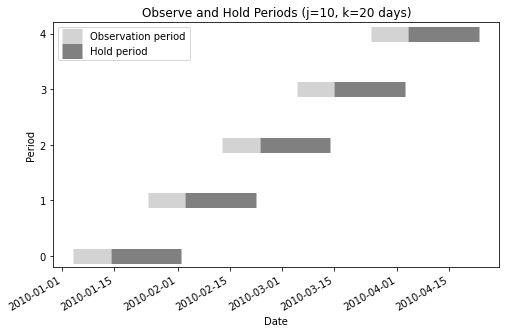

In [37]:
from matplotlib.dates import date2num
plotdf = df[df['index'] < 5][['index', 'date']]
plotdf['date'] = pd.to_datetime(plotdf['date'])

ax = plotdf.set_index('date').plot(figsize=(8, 5), title='Observe and Hold Periods (j=10, k=20 days)', yticks=[0,1,2,3,4], xlabel='Date', ylabel='Period')
ax.lines.pop(0)

for i in range(5):
    td = timedf.iloc[i]
    
    # ax.axvspan(td.j_start.strftime("%Y-%m-%d"), td.midpoint.strftime("%Y-%m-%d"), color='green', alpha=0.3)
    # ax.axvspan(td.midpoint.strftime("%Y-%m-%d"), td.k_end.strftime("%Y-%m-%d"), color='grey', alpha=0.3)
    ax.hlines(y=i, xmin=td.j_start.strftime("%Y-%m-%d"), xmax=td.midpoint.strftime("%Y-%m-%d"), linewidth=15, color='#d3d3d3', label='Observation period' if i==0 else '_nolegend_')
    ax.hlines(y=i,xmin=td.midpoint.strftime("%Y-%m-%d"), xmax=td.k_end.strftime("%Y-%m-%d"), linewidth=15, color='grey', label='Hold period' if i==0 else '_nolegend_')

ax.legend(loc='upper left')#.remove()
plt.show();


In [38]:
timedf.iloc[0].j_start.strftime("%Y-%m-%d")
timedf.iloc[0].midpoint.strftime("%Y-%m-%d")

'2010-01-14'

In [47]:
get_j_df(0).date.count()

date              9
open              9
high              9
low               9
close             9
adj_close         9
volume            9
pctc              9
cumprod           9
index             9
mom_pct_change    9
rev_pct_change    9
CCI_4_0.015       9
K_4_3             9
D_4_3             9
J_4_3             9
RSI_4             9
BOP               9
WILLR_4           9
PDIST             9
KCLe_4_2          9
KCBe_4_2          9
KCUe_4_2          9
ADX_4             9
DMP_4             9
DMN_4             9
QS_4              9
ROC_4             9
STDEV_4           9
PVOL              9
EFI_4             9
dtype: int64

In [43]:
per0 = get_j_df(0)
per0.head()

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCBe_4_2,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0,...,1125.862247,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0,...,1130.125356,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0,...,1132.931219,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0,...,1136.434708,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0,...,1139.852817,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10


In [44]:
per0['mom_cum_ret'] = (per0['mom_pct_change']+1).cumprod()-1
per0['rev_cum_ret'] = (per0['rev_pct_change']+1).cumprod()-1
per0

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,mom_cum_ret,rev_cum_ret
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0,...,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10,0.000000,0.000000
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0,...,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10,0.027465,-0.004083
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0,...,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10,0.051667,-0.022766
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0,...,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10,0.129314,-0.027102
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0,...,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10,0.128945,-0.041748
5,2010-01-11,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4255780000,0.001747,11.373502,0,...,50.133800,36.581995,5.866983,3.082489,0.920350,4.299231,4.881294e+12,1.288288e+10,0.152255,-0.055975
6,2010-01-12,1143.810059,1143.810059,1131.770020,1136.219971,1136.219971,4716160000,-0.009381,10.328688,0,...,40.024110,23.266002,28.261626,0.827454,-0.080909,4.701463,5.358595e+12,-1.256865e+10,0.175668,-0.090007
7,2010-01-13,1137.310059,1148.400024,1133.180054,1145.680054,1145.680054,4170360000,0.008326,11.247277,0,...,33.664016,25.518823,19.022968,1.564972,0.349492,4.900584,4.777898e+12,8.239593e+09,0.202810,-0.084555
8,2010-01-14,1145.680054,1150.410034,1143.800049,1148.459961,1148.459961,3915200000,0.002426,11.517210,0,...,31.337741,26.297119,15.995175,1.144958,0.303934,5.527932,4.496450e+12,9.297313e+09,0.236339,-0.098202


leptokurtic distribution
the only things we can do is buy, hold, or leave for rev or momentum
<br><br>choices:
- momentum
- reversal
- neither

if we want to give them data 